In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import json
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from base import ModelHelper
import xgboost

%load_ext autoreload
%autoreload 2

In [2]:
model_helper = ModelHelper("./reduce_float_dims_pca", "reduce_float_dims_pca")
model_helper

Model Folder = ./reduce_float_dims_pca
Metadata Folder = ./reduce_float_dims_pca/metadata
Path to data = ./raw-data/full_data.gz
Path to test data = ./raw-data/test_labelled.gz
Path to evaluation folder = ./reduce_float_dims_pca/evaluation
Seed = 1

In [3]:
df = model_helper.prepare_data(model_helper.path_to_full_data)

In [4]:
df_float = df.select_dtypes(include=['float64'])
scaler = StandardScaler()
rescaled_floats = scaler.fit_transform(df_float)
df_float_normed = pd.DataFrame(rescaled_floats, index=df_float.index, columns=df_float.columns)

In [5]:
pca = PCA()
rescaled_transformed_floats = pca.fit_transform(rescaled_floats)

In [6]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([3.76713963e-01, 2.74836118e-01, 1.13857231e-01, 7.27019913e-02,
       6.05400081e-02, 4.80107303e-02, 2.72947023e-02, 1.39876565e-02,
       4.58078193e-03, 3.41711818e-03, 2.63984666e-03, 7.41085468e-04,
       3.62995650e-04, 2.26931249e-04, 8.88407461e-05])

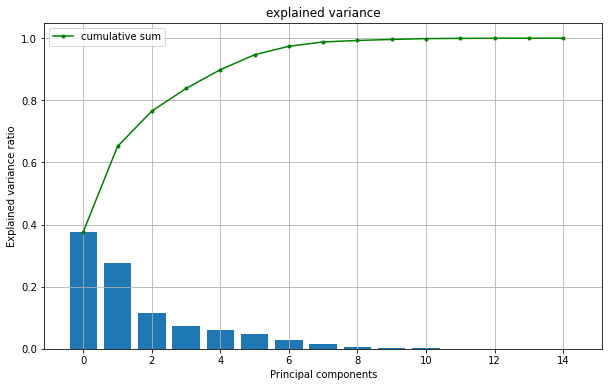

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_variance)), explained_variance, align='center')
plt.plot(range(len(explained_variance)), explained_variance.cumsum(), marker='.', color='g', label='cumulative sum')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('explained variance')
plt.legend()
plt.grid()

In [8]:
rescaled_transformed_floats = pd.DataFrame(rescaled_transformed_floats)
rescaled_transformed_floats.columns = [f"PCA{i}" for i in range(1, rescaled_transformed_floats.shape[1] + 1)]
df.drop(columns=list(df.select_dtypes(include=['float64']).columns), inplace=True)
df = pd.merge(df, rescaled_transformed_floats, left_index=True, right_index=True)
df.drop(columns=[f"PCA{i}" for i in range(7, rescaled_transformed_floats.shape[1] + 1)], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074992 entries, 0 to 1074991
Data columns (total 44 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   duration            1074992 non-null  int64  
 1   service             1074992 non-null  int64  
 2   src_bytes           1074992 non-null  int64  
 3   dst_bytes           1074992 non-null  int64  
 4   land                1074992 non-null  int64  
 5   wrong_fragment      1074992 non-null  int64  
 6   urgent              1074992 non-null  int64  
 7   hot                 1074992 non-null  int64  
 8   num_failed_logins   1074992 non-null  int64  
 9   logged_in           1074992 non-null  int64  
 10  num_compromised     1074992 non-null  int64  
 11  root_shell          1074992 non-null  int64  
 12  su_attempted        1074992 non-null  int64  
 13  num_root            1074992 non-null  int64  
 14  num_file_creations  1074992 non-null  int64  
 15  num_shells     

### Combine processing pipeline and modelling

In [10]:
def dimension_reduction_transformation(df, scaler=None, pca=None, min_dim_remove=None):
    min_dim_remove = 7 if min_dim_remove is None else min_dim_remove
    df_float = df.select_dtypes(include=['float64'])
    if scaler is None or 'n_samples_seen_' not in vars(scaler):
        scaler = StandardScaler()
        rescaled_floats = scaler.fit_transform(df_float)
    else:
        rescaled_floats = scaler.transform(df_float)
    if pca is None or 'n_samples_' not in vars(pca):
        pca = PCA(random_state=1)
        rescaled_transformed_floats = pca.fit_transform(rescaled_floats)
    else:
        rescaled_transformed_floats = pca.transform(rescaled_floats)
    rescaled_transformed_floats = pd.DataFrame(rescaled_transformed_floats)
    rescaled_transformed_floats.columns = [f"PCA{i}" for i in range(1, rescaled_transformed_floats.shape[1] + 1)]
    df.drop(columns=list(df.select_dtypes(include=['float64']).columns), inplace=True)
    df = pd.merge(df, rescaled_transformed_floats, left_index=True, right_index=True)
    df.drop(columns=[f"PCA{i}" for i in range(min_dim_remove, rescaled_transformed_floats.shape[1] + 1)], inplace=True)
    return df, scaler, pca

In [11]:
model_helper = ModelHelper("./reduce_float_dims_pca", "reduce_float_dims_pca")
df = model_helper.prepare_data(model_helper.path_to_full_data)
test = model_helper.prepare_data(model_helper.path_to_test_data)

scaler = StandardScaler()
pca = PCA(random_state=model_helper.seed)
df, scaler, pca = dimension_reduction_transformation(df, scaler, pca)
test, scaler, pca = dimension_reduction_transformation(test, scaler, pca)

X_train = df[[col for col in df.columns if col != 'target']]
y_train = df['target']
X_test = test[[col for col in test.columns if col != 'target']]
y_test = test['target']

In [12]:
xgb_model = xgboost.XGBClassifier(random_state=model_helper.seed)

In [13]:
best_params = model_helper.random_grid_search(
    X_train, y_train,
    model=xgb_model,
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 102.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 102.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 102.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 103.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 103.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 138.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 139.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 161.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 161.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 163.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 163.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 165.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 213.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 213.8min
[Parallel(n_jobs=-1)]: Done  15 tasks    

In [14]:
best_params

{'subsample': 0.75,
 'n_estimators': 100,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 5}

In [15]:
xgb_model = xgboost.XGBClassifier(**best_params, random_state=model_helper.seed)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.00618	validation_1-error:0.08006
[1]	validation_0-error:0.00618	validation_1-error:0.08006
[2]	validation_0-error:0.00614	validation_1-error:0.08003
[3]	validation_0-error:0.00614	validation_1-error:0.08003
[4]	validation_0-error:0.00592	validation_1-error:0.07751
[5]	validation_0-error:0.00534	validation_1-error:0.07738
[6]	validation_0-error:0.00571	validation_1-error:0.08045
[7]	validation_0-error:0.00449	validation_1-error:0.07531
[8]	validation_0-error:0.00281	validation_1-error:0.07439
[9]	validation_0-error:0.00249	validation_1-error:0.07328
[10]	validation_0-error:0.00184	validation_1-error:0.07047
[11]	validation_0-error:0.00182	validation_1-error:0.07036
[12]	validation_0-error:0.00167	validation_1-error:0.07085
[13]	validation_0-error:0.00154	validation_1-error:0.07138
[14]	validation_0-error:0.00148	validation_1-error:0.06939
[15]	validation_0-error:0.00114	validation_1-error:0.06911
[16]	validation_0-error:0.00092	validation_1-error:0.06896
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
model_helper.model = xgb_model
model_helper.save_model()

              precision    recall  f1-score   support

      normal       0.92      0.99      0.95     47913
      attack       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291



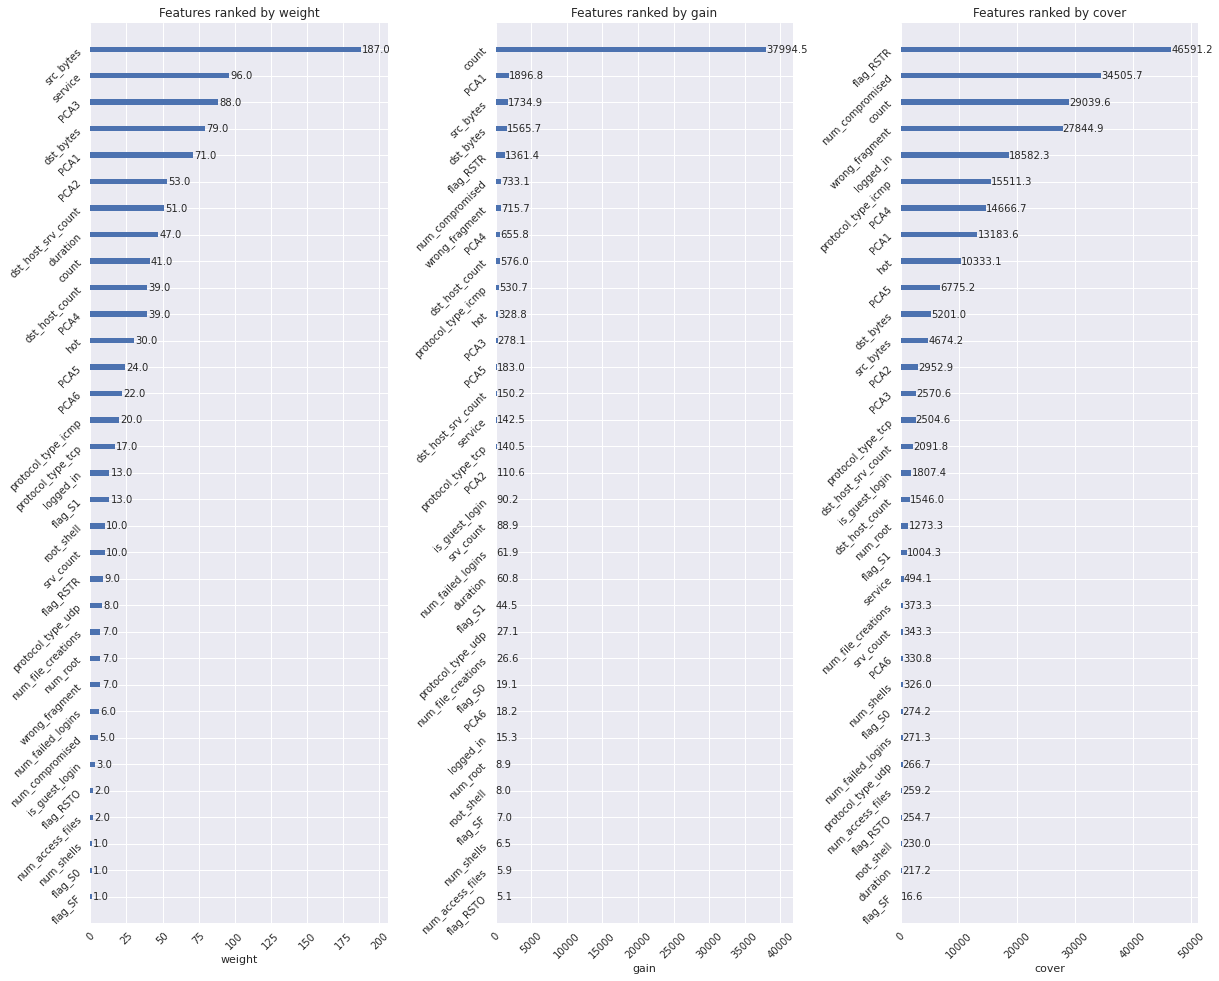

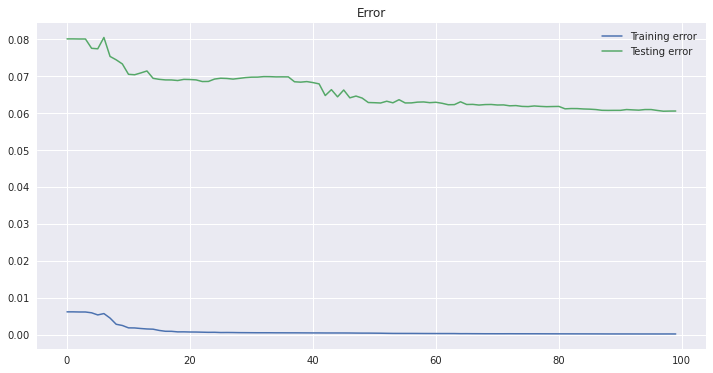

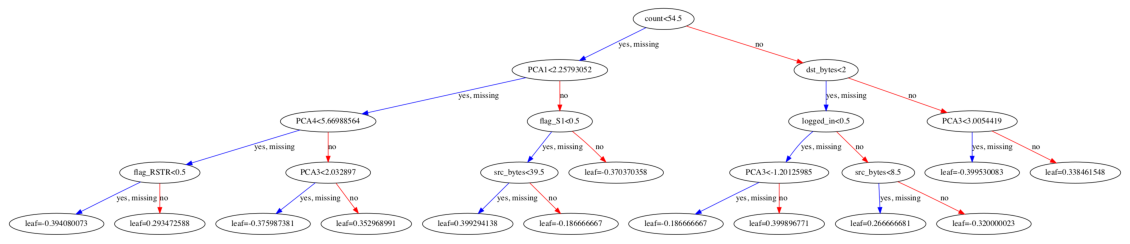

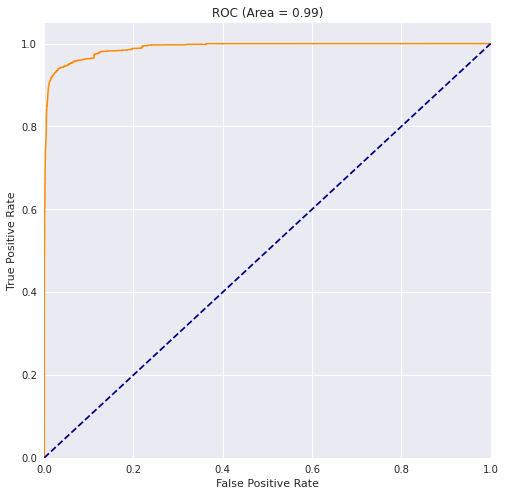

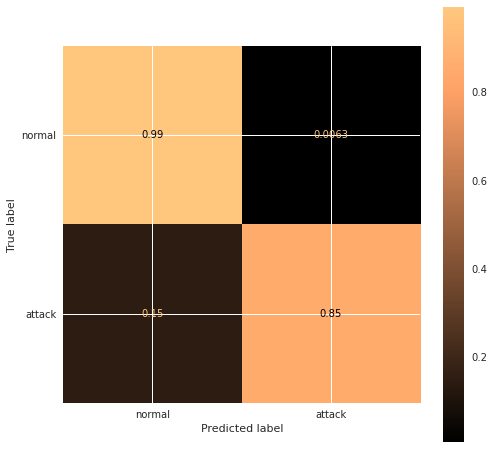

In [17]:
evaluation = model_helper.evaluate_model(X_test, y_test)

In [18]:
evaluation

{'accuracy': 0.9394625506203828,
 'balanced_accuracy': 0.8447342053927005,
 'prfs': {'precision': {'normal': 0.915839489073561,
   'attack': 0.987987513336231},
  'recall': {'normal': 0.9936551666562311, 'attack': 0.8510790387364695},
  'f1_score': {'normal': 0.9531617566093075, 'attack': 0.9144372314162933},
  'support': {'normal': 47913.0, 'attack': 29378.0}},
 'test_target_proportions': {False: 0.6199039991719605,
  True: 0.38009600082803946},
 'model_params': {'objective': 'binary:logistic',
  'base_score': 0.5,
  'booster': 'gbtree',
  'colsample_bylevel': 1,
  'colsample_bynode': 1,
  'colsample_bytree': 1,
  'gamma': 5,
  'gpu_id': -1,
  'importance_type': 'gain',
  'interaction_constraints': '',
  'learning_rate': 0.2,
  'max_delta_step': 0,
  'max_depth': 4,
  'min_child_weight': 1,
  'missing': nan,
  'monotone_constraints': '()',
  'n_estimators': 100,
  'n_jobs': 0,
  'num_parallel_tree': 1,
  'random_state': 1,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1,
